# Solving Inverse Problems with Pretrained Convex-Ridge Regularizers

This notebook gives a few basic snippets to use CRR-NNs.

In [4]:
import torch
from convex_reg import utils

In [5]:
gpu = False

if gpu:
    device = 'cuda:0'
    torch.set_grad_enabled(False)
    torch.set_num_threads(4)
else:
    device = 'cpu'

## 1. Loading and Pruning a Model

Each CRR-NN was trained with a noise level $\sigma\in\{5/255, 25/255\}$ with a $t$-step denoising process, for $t\in\{1, 2, 5, 10, 20, 30, 50\}$.

In [8]:
sigma_training = 25
t = 5
dir_name = '/Users/tliaudat/Documents/postdoc/github/convex_ridge_regularizers/trained_models/'
exp_name = f'Sigma_{sigma_training}_t_{t}/'
model = utils.load_model(dir_name+exp_name, device, gpu=gpu)


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------


 Prunning CRR-NNs:
 - The training of CRR-NNs is carried out with a regularization on the activation functions. This typically yields some activation functions to be almost vanishing. The associated filters can hence be removed.
 - The training is carried out with composition of convolutions. After training, these can be turned into standard convolutions for improved efficiency.

In [9]:
print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183


## 2. Using the Models

Lipschitz bound

In [10]:
# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L = model.L.data.item()
print(f"Lipschitz bound {L:.3f}")

Lipschitz bound 1.479


Gradient

In [11]:
im = torch.empty((1, 1, 100, 100), device=device).uniform_()
grad = model.grad(im)# alias for model.forward(im) and hence model(im)

Regularization Cost

The regularization cost is not used during training. On the fisrt call, the construction of the potential functions is triggered. Th activation functions are expressed with linear B-splines and the profile functions with quadratic B-splines.

In [12]:
im = torch.empty((1, 1, 100, 100), device=device).uniform_()
cost = model.cost(100*im)

-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


## A Toy Example

We give a toy example of image denoising.

In [13]:
import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm

In [16]:
img = cv2.resize(cv2.imread("/Users/tliaudat/Documents/postdoc/github/convex_ridge_regularizers/image/sample.JPG", cv2.IMREAD_GRAYSCALE), (504, 378))
img_torch = torch.tensor(img, device=device).reshape((1,1) + img.shape)/255
img_torch_noisy = img_torch + 25/255 * torch.randn_like(img_torch)

In [21]:
print(img_torch_noisy.dtype)

torch.float32


The denoising is viewed as an inverse problem. The optimization problem is solved with accelerated gradient descent.

In [10]:
# optimization settings
tol = 1e-4
n_iter_max = 100
lmbd = 12
mu = 20

# stepsize rule
L = model.L
alpha = 1/( 1 + mu * lmbd * L)

# initialization
x = torch.clone(img_torch_noisy)
z = torch.clone(img_torch_noisy)
t = 1

for i in tqdm(range(n_iter_max)):
    x_old = torch.clone(x)
    x = z - alpha*((z - img_torch_noisy) + lmbd * model(mu * z))
    # possible constraint, AGD becomes FISTA
    # e.g. if positivity
    # x = torch.clamp(x, 0, None)
    
    t_old = t 
    t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
    z = x + (t_old - 1)/t * (x - x_old)

    # relative change of norm for terminating
    res = (torch.norm(x_old - x)/torch.norm(x_old)).item()
    if res < tol:
        break

100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Visualization

[]

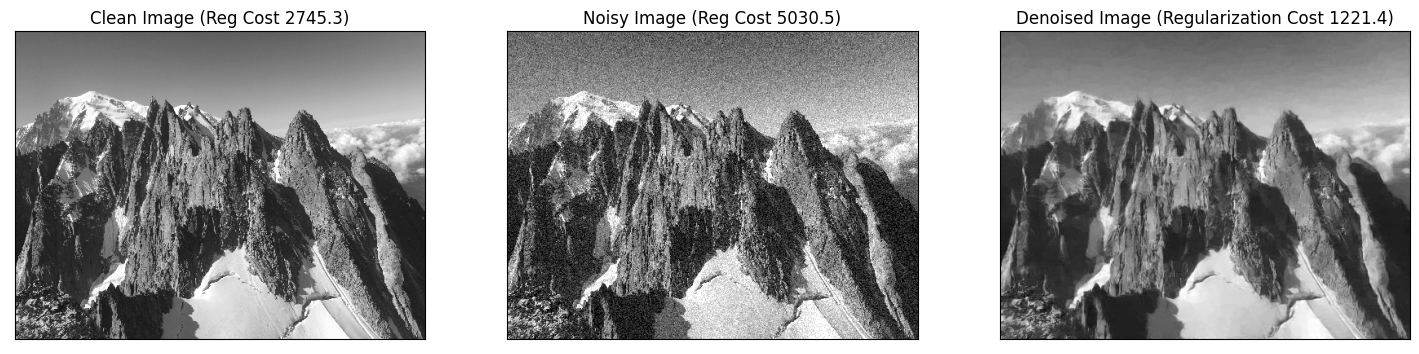

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
ax[0].set_title(f"Clean Image (Reg Cost {model.cost(mu*img_torch)[0].item():.1f})")
ax[0].imshow(img_torch.detach().cpu().squeeze(), cmap="gray", vmin=0, vmax=1)
ax[0].set_yticks([])
ax[0].set_xticks([])

ax[1].set_title(f"Noisy Image (Reg Cost {model.cost(mu*img_torch_noisy)[0].item():.1f})")
ax[1].imshow(img_torch_noisy.detach().cpu().squeeze(), cmap="gray", vmin=0, vmax=1)
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[2].set_title(f"Denoised Image (Regularization Cost {model.cost(mu*x)[0].item():.1f})")
ax[2].imshow(x.detach().cpu().squeeze(), cmap="gray", vmin=0, vmax=1)
ax[2].set_yticks([])
ax[2].set_xticks([])